# Q2. Image Classification
## Part 1

(a) (1 point) Download the dataset and use the following mapping as the class labels: 

{’amur leopard’: 0, ’amur tiger’: 1, ’birds’: 2, ’black bear’: 3, ’brown bear’: 4, ’dog’: 5, ’roe deer’: 6, ’sika deer’: 7, ’wild boar’: 8, ’people’: 9} 

Perform a stratified random split of the data in the ratio 0.7:0.1:0.2 to get the train, validation and the test sets. 

Create a custom Dataset class for the data. Initialize Weights & Biases (WandB)(Video Tutorial).

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torchvision.io import read_image

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
data_dir = 'data\Cropped_final'

class_labels_mapping = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear': 4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

def create_label_csv(image_paths, labels, output_csv):
    if len(image_paths) != len(labels):
        raise ValueError("Number of image paths and labels must be the same")

    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for image_path, label in zip(image_paths, labels):
            writer.writerow([image_path, label])

#function to load data and assign labels to folder
def load_dataset(data_dir, class_labels_mapping):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        if class_name in class_labels_mapping:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith('.jpg'):  # Assuming images are in jpg format
                        image_path = os.path.join(class_dir, file)
                        images.append(image_path)
                        labels.append(class_labels_mapping[class_name])
    return images, labels


images, labels = load_dataset(data_dir, class_labels_mapping)

#splitting 70:20:10
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, stratify=labels)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.2, stratify=temp_labels)


#created csvs on initial run, no need to do again but uncomment if necessary in demo

# create_label_csv(train_images, train_labels, "train_labels.csv")
# create_label_csv(val_images, val_labels, "val_labels.csv")
# create_label_csv(test_images, test_labels, "test_labels.csv")


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


train_dataset = CustomImageDataset("train_labels.csv", data_dir)
val_dataset = CustomImageDataset("val_labels.csv", data_dir)
test_dataset = CustomImageDataset("test_labels.csv", data_dir)

(b) (2 points) Create data loaders for all the splits (train, val and test) using PyTorch.

In [3]:
batch_size = 32 #default online value

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

(c) (2 points) Visualize the data distribution across class labels for training and validation sets.

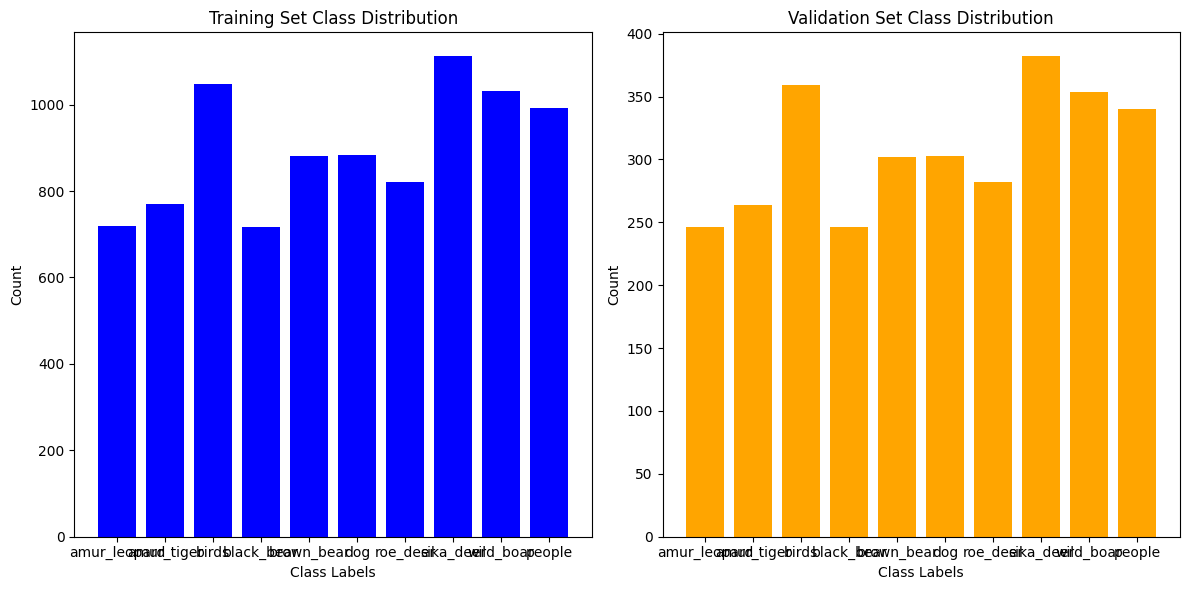

In [4]:
def count_classes(labels, num_classes):
    class_counts = [0] * num_classes
    for label in labels:
        class_counts[label] += 1
    return class_counts

train_class_counts = count_classes(train_labels, len(class_labels_mapping))
val_class_counts = count_classes(val_labels, len(class_labels_mapping))

class_labels = list(class_labels_mapping.keys())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(train_class_counts)), train_class_counts, tick_label=class_labels, color='blue')
plt.title('Training Set Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(range(len(val_class_counts)), val_class_counts, tick_label=class_labels, color='orange')
plt.title('Validation Set Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Part 2

(a) (3.5 points) Create a CNN architecture with 3 Convolution Layers having a kernel size of 3×3 and padding and stride of 1. 

Use 32 feature maps for the first layer, 64 for the second and 128 for the last convolution layer. 

Use a Max pooling layer having kernel size of 4×4 with stride 4 after the first convolution layer and a Max pooling layer having kernel size of 2×2 with stride 2 after the second and third convolution layers. 

Finally flatten the output of the final Max pooling layer and add a classification head on top of it. Use ReLU activation functions wherever applicable.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#object of the CNN
model = CNN()

(b) (3 points) Train the model using the Cross-Entropy Loss and Adam optimizer for 10 epochs. 

Use wandb to log the training and validation losses and accuracies.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
import wandb

wandb.init(project="cnn-from-scratch")

In [10]:
# Train the model
for epoch in range(10):  #10 epochs
    curr_loss = 0.0
    corr = 0
    tot = 0
    for i, data in enumerate(train_loader, 0): #error in train loader path setting
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #training loss
        curr_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        tot += labels.size(0)
        corr += (predicted == labels).sum().item()

    train_loss = curr_loss / len(train_loader)
    train_accuracy = 100 * corr / tot

    #validation task
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print("Epoch {}/{}: Train Loss: {}, Train Accuracy: {}%, Val Loss: {}, Val Accuracy: {}%".format(epoch+1,10,train_loss,train_accuracy,val_loss))

    wandb.log({"Train Loss": train_loss, "Train Accuracy": train_accuracy, "Val Loss": val_loss, "Val Accuracy": val_accuracy})

wandb.finish()

RuntimeError: [Errno 2] No such file or directory: 'data\Cropped_final\data\Cropped_final\black_bear\0934_blb_n_cub_crop00_detections.jpg'

(c) (0.5 points) Look at the training and validation loss plots and comment whether the model is overfitting or not.

(d) (3 points) Report the Accuracy and F1-Score on the test set. Also, log the confusion matrix using wandb.

In [ ]:
model.eval()
test_correct = 0
test_total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy = 100 * test_correct / test_total
print("Test Accuracy: {}%".format(test_accuracy))

f1 = f1_score(true_labels, predictions, average='macro')
print("F1-Score: {}".format(f1))

wandb.log({"Test Accuracy": test_accuracy, "F1-Score": f1})